In [1]:
from autots import AutoTS,model_forecast
from autots.datasets import load_hourly
import pandas as pd
import numpy as np
from openpyxl import load_workbook
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
import pmdarima as pm
from autots import load_daily, model_forecast

In [2]:
def update_excel_intensities(filename,df,sheet,mode='a'):
    if mode=='a':
        with pd.ExcelWriter(filename,mode=mode, if_sheet_exists='replace') as writer:  
            df.to_excel(writer, sheet_name=sheet)
    else:
        with pd.ExcelWriter(filename,mode=mode) as writer:  
            df.to_excel(writer, sheet_name=sheet)
    
def read_excel_sheet(file,sheetname):
    customers = pd.read_excel(file,
        sheet_name=sheetname,
        header=0,
        index_col=0,
        keep_default_na=True
        )
    return customers

def read_csv(file,sheetname):
    customers = pd.read_csv(file,
        header=0,
        sep=';',
        index_col=0,
        keep_default_na=True
        )
    
    customers.fillna(0,inplace=True)
    
    return customers

def div100(x):
    return x/100.0

def mul100(x):
    return x*100.0

def logistic(x):
    return np.log(x/(1-x))

def invlogistic(x):
    return np.exp(x)/(1+np.exp(x))

def onex(x):
    return x/(1-x)

def invonex(x):
    return x/(1+x)

def onex2(x):
    return x*x/(1-x*x)

def invonex2(x):
    return np.sqrt(x/(1+x))

In [5]:
#data = read_excel_sheet('data/predictions_backtesting_2023.xlsx','2022')
data = read_excel_sheet('data/testdata_2024.xlsx','data')
print(data)
data=data[data.index<2024]#iloc[:10,:]


       hedelmallisyysluku  pienituloisuus_miehet_18_29  \
vuosi                                                    
1989                1.710                          9.4   
1990                1.782                          7.9   
1991                1.794                         10.9   
1992                1.847                         13.5   
1993                1.813                         12.7   
1994                1.847                         14.2   
1995                1.807                         15.9   
1996                1.764                         19.3   
1997                1.746                         18.2   
1998                1.700                         17.9   
1999                1.735                         18.2   
2000                1.729                         16.7   
2001                1.726                         19.2   
2002                1.718                         21.0   
2003                1.760                         21.1   
2004          

In [6]:
#data=data.reset_index(drop=True)
#data.index2 = data.index
#display(data.index)
#for k,v in enumerate(x):
#    data.loc[str(v),'index2'] = str(v)
#data=data.set_index(data.index2,inplace=True)
data.index = pd.to_datetime(data.index,format='%Y')
display(data)


,hedelmallisyysluku,pienituloisuus_miehet_18_29,pienituloisuus_naiset_18_29,lapsikuolleisuus,synnyttajien_keskiika,sisempikaupunki,ulompikaupunki,kehyskaupunki,maaseudulla,avioituvuus_naiset_30_34,...,some_25_34,some_35_44,työttömyys_miehet_25_34,työttömyys_naiset_25_34,työllisyysaste_miehet_25_34,työllisyysaste_naiset_25_34,työttömyys_miehet_35_44,työttömyys_naiset_35_44,työllisyysaste_miehet_35_44,työllisyysaste_naiset_35_44
vuosi,,,,,,,,,,,,,,,,,,,,,
1989-01-01,1.710,9.4,11.4,0.006029,29.080000,29.075531,23.470945,9.400502,36.745385,49.60,...,0.000000,0.000000,2.9,2.7,90.2,81.7,3.1,1.9,92.0,88.2
1990-01-01,1.782,7.9,11.4,0.005656,29.160071,29.075531,23.470945,9.400502,36.745385,51.40,...,0.000000,0.000000,2.7,2.1,90.7,80.6,2.7,1.5,92.1,88.3
1991-01-01,1.794,10.9,13.2,0.005804,29.170250,28.980243,23.768951,9.459372,36.588651,50.50,...,0.000000,0.000000,5.9,2.8,86.9,78.3,4.5,2.4,89.9,86.5
1992-01-01,1.847,13.5,13.9,0.005168,29.273838,28.863763,24.030293,9.515345,36.402128,49.50,...,0.000000,0.000000,12.6,7.7,78.8,72.5,10.6,6.0,83.6,81.4
1993-01-01,1.813,12.7,13.8,0.004299,29.360658,28.916610,24.226395,9.541993,36.185641,53.60,...,0.000000,0.000000,18.5,14.0,72.5,66.5,15.3,10.2,78.6,77.8
1994-01-01,1.847,14.2,16.6,0.004729,29.504384,29.135942,24.351950,9.520954,35.868999,54.20,...,0.000000,0.000000,20.8,16.5,70.8,64.0,16.6,12.7,77.0,76.3
1995-01-01,1.807,15.9,17.1,0.003858,29.687610,29.446438,24.418790,9.517619,35.486999,52.60,...,0.000000,0.000000,16.1,16.9,74.9,62.7,13.4,12.6,80.1,77.1
1996-01-01,1.764,19.3,20.3,0.003896,29.755130,29.692128,24.465213,9.524036,35.117315,55.40,...,0.000000,0.000000,15.1,16.4,75.6,63.5,12.4,11.1,80.4,78.4
1997-01-01,1.746,18.2,21.5,0.003859,29.852071,29.938751,24.526917,9.559717,34.744759,51.10,...,0.000000,0.000000,13.2,15.5,77.3,64.1,10.8,11.0,81.3,76.9


In [7]:

#df_wide = load_hourly(long=False)
#display(df_wide)

# here we care most about traffic volume, all other series assumed to be weight of 1
weights_hourly = {} #'traffic_volume': 20}

model_list = [
    #'ETS',
    'VECM',
    #'Theta',
    'ARDL',
    #'RollingRegression',
    #'FBProphet',
    'KalmanStateSpace',
    #'WindowRegression',
    #'UnivariateRegression',
    #'PytorchForecasting',
    'LATC',
    #'Constan
]

model = AutoTS(
    forecast_length=10,
    frequency='infer',
    prediction_interval=0.90,
    no_negatives=True,
    ensemble=['all'],
    max_generations=5,
    num_validations=1,
    validation_method='Backwards',
    model_list=model_list,
    transformer_list='all',
    models_to_validate=0.2,
    drop_most_recent=0,
    n_jobs='auto',
)

model = model.fit(
    data
)

prediction = model.predict()
forecasts_df = prediction.forecast
# prediction.long_form_results()


Using 7 cpus for n_jobs.
Data frequency is: AS-JAN, used frequency is: AS-JAN
Model Number: 1 with model VECM in generation 0 of 5
Template Eval Error: Exception('Transformer PowerTransformer failed on fit') in model 1 in generation 0: VECM
Model Number: 2 with model VECM in generation 0 of 5
Model Number: 3 with model VECM in generation 0 of 5
Template Eval Error: Exception('Transformer PCA failed on fit') in model 3 in generation 0: VECM
Model Number: 4 with model ARDL in generation 0 of 5
Model Number: 5 with model VECM in generation 0 of 5
Template Eval Error: Exception('Transformer AlignLastValue failed on fit') in model 5 in generation 0: VECM
Model Number: 6 with model ARDL in generation 0 of 5
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 6 in generation 0: ARDL
Model Number: 7 with model KalmanStateSpace in generation 0 of 5


/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/pandas/core/dtypes/astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


Model Number: 8 with model LATC in generation 0 of 5
Model Number: 9 with model ARDL in generation 0 of 5
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 9 in generation 0: ARDL
Model Number: 10 with model VECM in generation 0 of 5
Model Number: 11 with model VECM in generation 0 of 5
Model Number: 12 with model VECM in generation 0 of 5
Template Eval Error: Exception('Transformer PCA failed on fit') in model 12 in generation 0: VECM
Model Number: 13 with model KalmanStateSpace in generation 0 of 5
Template Eval Error: Exception('Transformer AlignLastValue failed on fit') in model 13 in generation 0: KalmanStateSpace
Model Number: 14 with model VECM in generation 0 of 5
Model Number: 15 with model VECM in generation 0 of 5
Template Eval Error: Exception('Transformer STLFilter failed on fit') in model 15 in generation 0: VECM
Model Number: 16 with model VECM in generation 0 of 5
Template Eval Error: Exception('Transformer RegressionFi

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/autots/tools/window_functions.py:468: RuntimeWarning: invalid value encountered in divide
  slope = (sxy - sx * sy) / (sx2 - sx**2)


Model Number: 19 with model LATC in generation 0 of 5
Template Eval Error: ValueError('LATC cannot accept any arrays that are all 0') in model 19 in generation 0: LATC
Model Number: 20 with model LATC in generation 0 of 5
Template Eval Error: ValueError('LATC cannot accept any arrays that are all 0') in model 20 in generation 0: LATC
Model Number: 21 with model KalmanStateSpace in generation 0 of 5
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 21 in generation 0: KalmanStateSpace
Model Number: 22 with model LATC in generation 0 of 5
Template Eval Error: ValueError('LATC cannot accept any arrays that are all 0') in model 22 in generation 0: LATC
Model Number: 23 with model LATC in generation 0 of 5
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 23 in generation 0: LATC
Model Number: 24 with model VECM in generation 0 of 5
Template Eval Error: ValueError("regression_type='User' but no future_regressor suppli

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/pandas/core/dtypes/astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/pandas/core/dtypes/astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/pandas/core/dtypes/astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/pandas/core/dtypes/astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/pandas/core/dtypes/astype.py:170

Template Eval Error: Exception('Transformer AlignLastValue failed on fit') in model 27 in generation 1: LATC
Model Number: 28 with model ARDL in generation 1 of 5
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 28 in generation 1: ARDL
Model Number: 29 with model ARDL in generation 1 of 5
Template Eval Error: Exception('Transformer PowerTransformer failed on fit') in model 29 in generation 1: ARDL
Model Number: 30 with model ARDL in generation 1 of 5
Model Number: 31 with model KalmanStateSpace in generation 1 of 5
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 31 in generation 1: KalmanStateSpace
Model Number: 32 with model KalmanStateSpace in generation 1 of 5
Template Eval Error: Exception('Transformer Detrend failed on fit') in model 32 in generation 1: KalmanStateSpace
Model Number: 33 with model KalmanStateSpace in generation 1 of 5
Template Eval Error: Exception('Transformer RegressionFil

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/vector_ar/vecm.py:1705: ComplexWarning: Casting complex values to real discards the imaginary part
  A[0] = pi + np.identity(K)
/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/vector_ar/vecm.py:1705: ComplexWarning: Casting complex values to real discards the imaginary part
  A[0] = pi + np.identity(K)


New Generation: 2 of 5
Model Number: 42 with model LATC in generation 2 of 5
Template Eval Error: ValueError('LATC cannot accept any arrays that are all 0') in model 42 in generation 2: LATC
Model Number: 43 with model ARDL in generation 2 of 5
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 43 in generation 2: ARDL
Model Number: 44 with model VECM in generation 2 of 5
Model Number: 45 with model KalmanStateSpace in generation 2 of 5
Model Number: 46 with model VECM in generation 2 of 5
Model Number: 47 with model ARDL in generation 2 of 5
Model Number: 48 with model KalmanStateSpace in generation 2 of 5
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 48 in generation 2: KalmanStateSpace
Model Number: 49 with model LATC in generation 2 of 5


/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/pandas/core/dtypes/astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/pandas/core/dtypes/astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/pandas/core/dtypes/astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/pandas/core/dtypes/astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


Model Number: 50 with model ARDL in generation 2 of 5
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 50 in generation 2: ARDL
Model Number: 51 with model ARDL in generation 2 of 5
Model Number: 52 with model KalmanStateSpace in generation 2 of 5
Model Number: 53 with model VECM in generation 2 of 5
Model Number: 54 with model VECM in generation 2 of 5
Template Eval Error: LinAlgError('Singular matrix') in model 54 in generation 2: VECM
Model Number: 55 with model VECM in generation 2 of 5
Model Number: 56 with model VECM in generation 2 of 5
Model Number: 57 with model LATC in generation 2 of 5
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 57 in generation 2: LATC
Model Number: 58 with model LATC in generation 2 of 5
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 58 in generation 2: LATC
Model Number: 59 with model ARDL in generation 2 of 5
Model Number: 60 with model V

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/pandas/core/dtypes/astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


Model Number: 63 with model KalmanStateSpace in generation 3 of 5
Model Number: 64 with model VECM in generation 3 of 5


/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/pandas/core/dtypes/astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


Model Number: 65 with model ARDL in generation 3 of 5
Model Number: 66 with model VECM in generation 3 of 5
Model Number: 67 with model LATC in generation 3 of 5
Model Number: 68 with model ARDL in generation 3 of 5


/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/pandas/core/dtypes/astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/pandas/core/dtypes/astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/pandas/core/dtypes/astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/pandas/core/dtypes/astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


Model Number: 69 with model KalmanStateSpace in generation 3 of 5
Model Number: 70 with model ARDL in generation 3 of 5
Model Number: 71 with model VECM in generation 3 of 5
Model Number: 72 with model VECM in generation 3 of 5
Template Eval Error: Exception('Transformer AlignLastValue failed on inverse') in model 72 in generation 3: VECM
Model Number: 73 with model KalmanStateSpace in generation 3 of 5
Model Number: 74 with model ARDL in generation 3 of 5
Template Eval Error: Exception('Transformer PCA failed on fit') in model 74 in generation 3: ARDL
Model Number: 75 with model VECM in generation 3 of 5
Template Eval Error: LinAlgError('Singular matrix') in model 75 in generation 3: VECM
Model Number: 76 with model KalmanStateSpace in generation 3 of 5
Model Number: 77 with model KalmanStateSpace in generation 3 of 5
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 77 in generation 3: KalmanStateSpace
Model Number: 78 with model KalmanStateSpace i

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Model Number: 83 with model KalmanStateSpace in generation 4 of 5
Model Number: 84 with model KalmanStateSpace in generation 4 of 5
Model Number: 85 with model VECM in generation 4 of 5
Template Eval Error: UFuncTypeError(<ufunc 'add'>, 'same_kind', dtype('complex128'), dtype('float64'), 2) in model 85 in generation 4: VECM
Model Number: 86 with model KalmanStateSpace in generation 4 of 5
Model Number: 87 with model ARDL in generation 4 of 5


/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/vector_ar/vecm.py:1705: ComplexWarning: Casting complex values to real discards the imaginary part
  A[0] = pi + np.identity(K)


Template Eval Error: ValueError("ARDL series hedelmallisyysluku failed with error ValueError('The number of regressors (120) including deterministics, lags of the endog, lags of the exogenous, and fixed regressors is larer than the sample available for estimation (22).') exog train             weekend  quarter  ...  weekdayofmonth_4  weekdayofmonth_5\nvuosi                         ...                                    \n1989-01-01        1        1  ...               0.0               0.0\n1990-01-01        0        1  ...               0.0               0.0\n1991-01-01        0        1  ...               0.0               0.0\n1992-01-01        0        1  ...               0.0               0.0\n1993-01-01        0        1  ...               0.0               0.0\n1994-01-01        1        1  ...               0.0               0.0\n1995-01-01        1        1  ...               0.0               0.0\n1996-01-01        0        1  ...               0.0               0.0\n1997-01

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Model Number: 103 with model VECM in generation 5 of 5
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 103 in generation 5: VECM
Model Number: 104 with model ARDL in generation 5 of 5
Model Number: 105 with model ARDL in generation 5 of 5
Model Number: 106 with model KalmanStateSpace in generation 5 of 5
Template Eval Error: Exception('Transformer PowerTransformer failed on fit') in model 106 in generation 5: KalmanStateSpace
Model Number: 107 with model ARDL in generation 5 of 5
Model Number: 108 with model LATC in generation 5 of 5
Template Eval Error: ValueError('LATC cannot accept any arrays that are all 0') in model 108 in generation 5: LATC
Model Number: 109 with model VECM in generation 5 of 5
Template Eval Error: UFuncTypeError(<ufunc 'add'>, 'same_kind', dtype('complex128'), dtype('float64'), 2) in model 109 in generation 5: VECM
Model Number: 110 with model KalmanStateSpace in generation 5 of 5
Model Number: 111 with model VECM in generat

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/statsmodels/tsa/vector_ar/vecm.py:1705: ComplexWarning: Casting complex values to real discards the imaginary part
  A[0] = pi + np.identity(K)


Model Number: 114 with model KalmanStateSpace in generation 5 of 5
Model Number: 115 with model ARDL in generation 5 of 5
Model Number: 116 with model LATC in generation 5 of 5
Model Number: 117 with model KalmanStateSpace in generation 5 of 5
Template Eval Error: Exception('Transformer RegressionFilter failed on fit') in model 117 in generation 5: KalmanStateSpace
TotalRuntime missing in 6!
Validation Round: 1
Model Number: 1 of 24 with model ARDL for Validation 1
📈 1 - ARDL with avg smape 22.81: 
Model Number: 2 of 24 with model LATC for Validation 1
📈 2 - LATC with avg smape 16.28: 
Model Number: 3 of 24 with model KalmanStateSpace for Validation 1
3 - KalmanStateSpace with avg smape 24.41: 
Model Number: 4 of 24 with model KalmanStateSpace for Validation 1


/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/autots/tools/probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/autots/tools/probabilistic.py:67: RuntimeWarning: divide by zero encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/autots/tools/probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


4 - KalmanStateSpace with avg smape 22.77: 
Model Number: 5 of 24 with model VECM for Validation 1
Template Eval Error: LinAlgError('Singular matrix') in model 5 in generation 0: VECM
Model Number: 6 of 24 with model KalmanStateSpace for Validation 1
6 - KalmanStateSpace with avg smape 22.68: 
Model Number: 7 of 24 with model KalmanStateSpace for Validation 1
7 - KalmanStateSpace with avg smape 22.68: 
Model Number: 8 of 24 with model ARDL for Validation 1
8 - ARDL with avg smape 22.88: 
Model Number: 9 of 24 with model KalmanStateSpace for Validation 1
9 - KalmanStateSpace with avg smape 21.94: 
Model Number: 10 of 24 with model ARDL for Validation 1
10 - ARDL with avg smape 23.78: 
Model Number: 11 of 24 with model ARDL for Validation 1
11 - ARDL with avg smape 29.95: 
Model Number: 12 of 24 with model KalmanStateSpace for Validation 1
12 - KalmanStateSpace with avg smape 39.81: 
Model Number: 13 of 24 with model KalmanStateSpace for Validation 1
13 - KalmanStateSpace with avg smape 

/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/autots/tools/probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/autots/tools/probabilistic.py:67: RuntimeWarning: divide by zero encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/autots/tools/probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


23 - LATC with avg smape 85.94: 
Model Number: 24 of 24 with model LATC for Validation 1
24 - LATC with avg smape 55.78: 
TotalRuntime missing in 7!
Validation Round: 1
TotalRuntime missing in 0!


/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/autots/tools/probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/autots/tools/probabilistic.py:67: RuntimeWarning: divide by zero encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
/Users/anttitanskanen/opt/miniconda3/envs/torch/lib/python3.9/site-packages/autots/tools/probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))


In [8]:
full_ensemble=pd.concat([data,forecasts_df])

In [9]:
full_ensemble

,hedelmallisyysluku,pienituloisuus_miehet_18_29,pienituloisuus_naiset_18_29,lapsikuolleisuus,synnyttajien_keskiika,sisempikaupunki,ulompikaupunki,kehyskaupunki,maaseudulla,avioituvuus_naiset_30_34,...,some_25_34,some_35_44,työttömyys_miehet_25_34,työttömyys_naiset_25_34,työllisyysaste_miehet_25_34,työllisyysaste_naiset_25_34,työttömyys_miehet_35_44,työttömyys_naiset_35_44,työllisyysaste_miehet_35_44,työllisyysaste_naiset_35_44
1989-01-01,1.710000,9.400000,11.400000,0.006029,29.080000,29.075531,23.470945,9.400502,36.745385,49.600000,...,0.000000,0.000000,2.900000,2.700000,90.200000,81.700000,3.100000,1.900000,92.000000,88.200000
1990-01-01,1.782000,7.900000,11.400000,0.005656,29.160071,29.075531,23.470945,9.400502,36.745385,51.400000,...,0.000000,0.000000,2.700000,2.100000,90.700000,80.600000,2.700000,1.500000,92.100000,88.300000
1991-01-01,1.794000,10.900000,13.200000,0.005804,29.170250,28.980243,23.768951,9.459372,36.588651,50.500000,...,0.000000,0.000000,5.900000,2.800000,86.900000,78.300000,4.500000,2.400000,89.900000,86.500000
1992-01-01,1.847000,13.500000,13.900000,0.005168,29.273838,28.863763,24.030293,9.515345,36.402128,49.500000,...,0.000000,0.000000,12.600000,7.700000,78.800000,72.500000,10.600000,6.000000,83.600000,81.400000
1993-01-01,1.813000,12.700000,13.800000,0.004299,29.360658,28.916610,24.226395,9.541993,36.185641,53.600000,...,0.000000,0.000000,18.500000,14.000000,72.500000,66.500000,15.300000,10.200000,78.600000,77.800000
1994-01-01,1.847000,14.200000,16.600000,0.004729,29.504384,29.135942,24.351950,9.520954,35.868999,54.200000,...,0.000000,0.000000,20.800000,16.500000,70.800000,64.000000,16.600000,12.700000,77.000000,76.300000
1995-01-01,1.807000,15.900000,17.100000,0.003858,29.687610,29.446438,24.418790,9.517619,35.486999,52.600000,...,0.000000,0.000000,16.100000,16.900000,74.900000,62.700000,13.400000,12.600000,80.100000,77.100000
1996-01-01,1.764000,19.300000,20.300000,0.003896,29.755130,29.692128,24.465213,9.524036,35.117315,55.400000,...,0.000000,0.000000,15.100000,16.400000,75.600000,63.500000,12.400000,11.100000,80.400000,78.400000
1997-01-01,1.746000,18.200000,21.500000,0.003859,29.852071,29.938751,24.526917,9.559717,34.744759,51.100000,...,0.000000,0.000000,13.200000,15.500000,77.300000,64.100000,10.800000,11.000000,81.300000,76.900000
1998-01-01,1.700000,17.900000,22.400000,0.004106,29.938362,30.162728,24.598141,9.606589,34.367804,52.700000,...,0.000000,0.000000,11.600000,13.000000,78.600000,66.600000,10.200000,8.600000,83.000000,79.100000


In [10]:
full_ensemble.columns

Index(['hedelmallisyysluku', 'pienituloisuus_miehet_18_29',
       'pienituloisuus_naiset_18_29', 'lapsikuolleisuus',
       'synnyttajien_keskiika', 'sisempikaupunki', 'ulompikaupunki',
       'kehyskaupunki', 'maaseudulla', 'avioituvuus_naiset_30_34',
       'avioituvuus_naiset_25_29', 'eronneisuus_25_29', 'eronneisuus_30_34',
       'kolmasaste_miehet_25_29', 'miehet_perusaste_25_29',
       'naiset_perusaste_25_29', 'kolmasaste_naiset_25_29', 'alypuhelin',
       'some_25_34', 'some_35_44', 'työttömyys_miehet_25_34',
       'työttömyys_naiset_25_34', 'työllisyysaste_miehet_25_34',
       'työllisyysaste_naiset_25_34', 'työttömyys_miehet_35_44',
       'työttömyys_naiset_35_44', 'työllisyysaste_miehet_35_44',
       'työllisyysaste_naiset_35_44'],
      dtype='object')

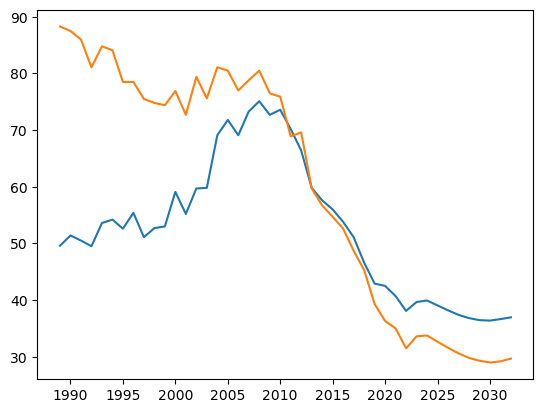

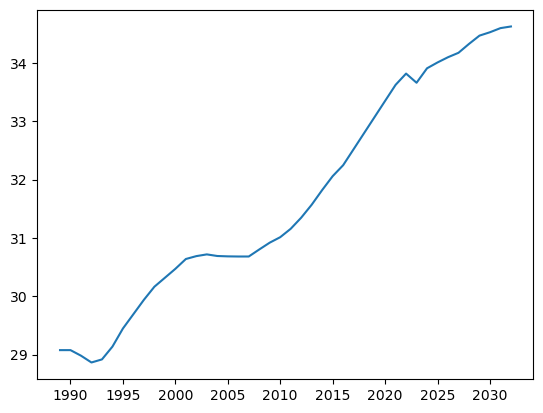

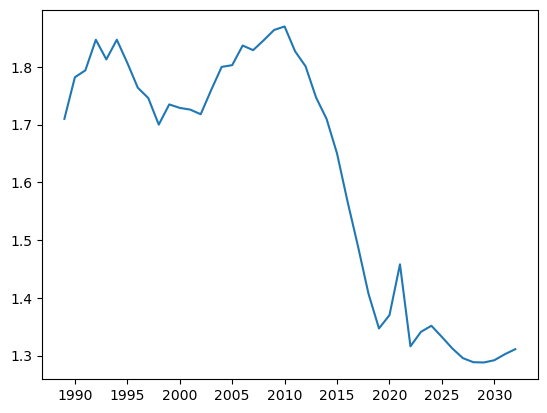

In [11]:
plt.plot(full_ensemble.avioituvuus_naiset_30_34)
plt.plot(full_ensemble.avioituvuus_naiset_25_29)
plt.show()
plt.plot(full_ensemble.sisempikaupunki)
plt.show()
plt.plot(full_ensemble.hedelmallisyysluku)

In [12]:
model_list = [
    'UnobservedComponents',
    'GLS',
    'ARCH',
    #'NeuralProphet',
    'GLM',
    'ETS',
    'VECM',
    'Theta',
    'ARDL',
    'RollingRegression',
    #'FBProphet',
    'KalmanStateSpace',
    'WindowRegression',
    'UnivariateRegression',
    'PytorchForecasting',
    'LATC',
    'ConstantNaive',
    'LastValueNaive',
    'AverageValueNaive',
    'VARMAX',
    'ARIMA'
]


def pred_model(m,df):
    df_forecast = model_forecast(
        model_name=m,
        model_param_dict={}, #'method': 'Mean'},
        model_transform_dict={
            #'fillna': 'mean',
            #'transformations': {'0': 'DifferencedTransformer'},
            #'transformation_params': {'0': {}}
        },
        df_train=df,
        forecast_length=10,
        frequency='infer',
        prediction_interval=0.9,
        no_negatives=False,
        # future_regressor_train=future_regressor_train2d,
        # future_regressor_forecast=future_regressor_forecast2d,
        random_seed=321,
        verbose=0,
        n_jobs="auto",
    )
    fd=df_forecast.forecast.head(10)
    
    return fd

def predict_models(model_list,data,transform=False):
    if transform:
        modata=data.copy().apply(div100).apply(onex2).apply(mul100)
    else:
        modata=data.copy()
    #print(modata)
    cols=list(data.columns)
    #print(cols,type(cols))
    mlist=model_list.copy()
    mlist.extend(['full'])
    print(mlist,model_list)
    ind = pd.MultiIndex.from_product([mlist,cols], names=['models','datasets'])
    full=pd.DataFrame(columns=ind)
    print(full)
    for m in model_list:
        print(m)
        if transform:
            fd=pred_model(m,modata).apply(div100).apply(invonex2).apply(mul100)
        else:
            fd=pred_model(m,modata)
        print(fd)
        full[m]=pd.concat([data,fd])
    print(fd,full_ensemble)
    print(pd.concat([data,fd]).shape,full_ensemble.shape)
    full['full']=full_ensemble
        
    return full

def plot_model(fulldf,dataset='avioituvuus_30_34'):
    mlist=model_list.copy()
    mlist.extend(['full'])
    for m in mlist:
        plt.plot(fulldf[m][dataset],label=m)    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(dataset)
    plt.show()


In [13]:
forecast=predict_models(model_list,data)

['UnobservedComponents', 'GLS', 'ARCH', 'GLM', 'ETS', 'VECM', 'Theta', 'ARDL', 'RollingRegression', 'KalmanStateSpace', 'WindowRegression', 'UnivariateRegression', 'PytorchForecasting', 'LATC', 'ConstantNaive', 'LastValueNaive', 'AverageValueNaive', 'VARMAX', 'ARIMA', 'full'] ['UnobservedComponents', 'GLS', 'ARCH', 'GLM', 'ETS', 'VECM', 'Theta', 'ARDL', 'RollingRegression', 'KalmanStateSpace', 'WindowRegression', 'UnivariateRegression', 'PytorchForecasting', 'LATC', 'ConstantNaive', 'LastValueNaive', 'AverageValueNaive', 'VARMAX', 'ARIMA']
Empty DataFrame
Columns: [(UnobservedComponents, hedelmallisyysluku), (UnobservedComponents, pienituloisuus_miehet_18_29), (UnobservedComponents, pienituloisuus_naiset_18_29), (UnobservedComponents, lapsikuolleisuus), (UnobservedComponents, synnyttajien_keskiika), (UnobservedComponents, sisempikaupunki), (UnobservedComponents, ulompikaupunki), (UnobservedComponents, kehyskaupunki), (UnobservedComponents, maaseudulla), (UnobservedComponents, avioituvu

            hedelmallisyysluku  pienituloisuus_miehet_18_29  \
2023-01-01            2.326789                    31.467168   
2024-01-01            2.370662                    32.060489   
2025-01-01            2.414654                    32.655436   
2026-01-01            2.458526                    33.248758   
2027-01-01            2.502398                    33.842079   
2028-01-01            2.546271                    34.435400   
2029-01-01            2.590263                    35.030347   
2030-01-01            2.634135                    35.623669   
2031-01-01            2.678007                    36.216990   
2032-01-01            2.721880                    36.810312   

            pienituloisuus_naiset_18_29  lapsikuolleisuus  \
2023-01-01                    33.887613          0.003941   
2024-01-01                    34.526572          0.004016   
2025-01-01                    35.167283          0.004090   
2026-01-01                    35.806242          0.004164   
2

ImportError: `arch` package must be installed from pip

In [ ]:
plot_model(forecast,'avioituvuus_naiset_30_34')
plot_model(forecast,'avioituvuus_naiset_25_29')
plot_model(forecast,'sisempikaupunki')
plot_model(forecast,'alypuhelin')
plot_model(forecast,'maaseudulla')
plot_model(forecast,'some_25_34')
plot_model(forecast,'some_35_44')
plot_model(forecast,'hedelmallisyysluku')